In [50]:
import sys
print(sys.version)

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [51]:
from os import path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import graphviz
# newly import

from matplotlib.colors import ListedColormap, Normalize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import mean_squared_error #MSE
#调用
# mean_squared_error(y_test,y_predict)

# ignore the warning you might get from importing ensemble from sklearn
from sklearn import ensemble

In [52]:
GDRIVE = 'LDR'
FILE_NAME = 'SCA_HLT_50Q_10T.csv'
BASE_PATH = '/Users/xinyu/Desktop/MoNeT_ML'
###############################################################################
# Load dataset
###############################################################################
expPath = path.join(BASE_PATH, GDRIVE, FILE_NAME)
DATA = pd.read_csv(expPath)
print('* Dataset Path: {}'.format(expPath))
print('* Dataset Dimensions: {}'.format(DATA.shape))
DATA.head()

* Dataset Path: /Users/xinyu/Desktop/MoNeT_ML\LDR\SCA_HLT_50Q_10T.csv
* Dataset Dimensions: (997741, 19)


,i_sex,i_ren,i_res,i_rsg,i_gsv,i_fch,i_fcb,i_fcr,i_hrm,i_hrf,i_grp,i_mig,TTI,TTO,WOP,POE,POF,CPT,MNF
0,1,0,0.00,0.000,0.000000e+00,0.000,0.000,0.0,0.0,0.000,0,0.0,1826.0,1826.0,0.0,0.0,1.0,1.000005,0.995371
1,1,1,0.05,0.079,0.000000e+00,0.175,0.117,0.0,1.0,0.956,0,0.0,105.0,403.0,298.5,0.0,1.0,0.720129,0.011812
2,1,1,0.05,0.079,1.000000e-08,0.175,0.117,0.0,1.0,0.956,0,0.0,105.0,403.0,299.0,0.0,1.0,0.720318,0.011814
3,1,1,0.05,0.079,1.000000e-06,0.175,0.117,0.0,1.0,0.956,0,0.0,105.0,403.0,298.0,0.0,1.0,0.720327,0.011880
4,1,1,0.05,0.079,1.000000e-04,0.175,0.117,0.0,1.0,0.956,0,0.0,105.0,402.0,297.5,0.0,1.0,0.720617,0.011890


In [53]:
###############################################################################
# Filter to "center" parameters
###############################################################################
fltr = (
    (DATA['i_grp'] == 0)    &
    (DATA['i_sex'] == 1)    &
    np.isclose(DATA['i_fch'], 0.175)    &
    np.isclose(DATA['i_fcb'], 0.117)    &
    np.isclose(DATA['i_fcr'], 0)        &
    np.isclose(DATA['i_hrm'], 1.0)      &
    np.isclose(DATA['i_hrf'], 0.956)    &
    np.isclose(DATA['i_rsg'], 0.079)    &
    np.isclose(DATA['i_gsv'], 1.e-02) 
)
df = DATA[fltr]
df.head()

,i_sex,i_ren,i_res,i_rsg,i_gsv,i_fch,i_fcb,i_fcr,i_hrm,i_hrf,i_grp,i_mig,TTI,TTO,WOP,POE,POF,CPT,MNF
5,1,1,0.05,0.079,0.01,0.175,0.117,0.0,1.0,0.956,0,0.0,106.0,343.0,237.0,0.0,1.0,0.752805,0.015845
10,1,1,0.10,0.079,0.01,0.175,0.117,0.0,1.0,0.956,0,0.0,94.0,332.0,238.0,0.0,1.0,0.752316,0.015478
15,1,1,0.15,0.079,0.01,0.175,0.117,0.0,1.0,0.956,0,0.0,86.0,326.0,239.0,0.0,1.0,0.751914,0.015082
20,1,1,0.20,0.079,0.01,0.175,0.117,0.0,1.0,0.956,0,0.0,82.0,322.0,240.0,0.0,1.0,0.751660,0.014895
195,1,1,0.25,0.079,0.01,0.175,0.117,0.0,1.0,0.956,0,0.0,78.0,320.0,242.0,0.0,1.0,0.750713,0.014629


In [54]:
def basic_position(pos):
    if pos < (1/3):
        return 'low'
    elif pos < (2/3) and pos >= (1/3) :
        return 'mid'
    return 'high'

DATA['CPTT'] = DATA['CPT'].apply(basic_position)
DATA['CPTT'].value_counts()

low     531813
high    248554
mid     217374
Name: CPTT, dtype: int64

In [55]:
DATA

,i_sex,i_ren,i_res,i_rsg,i_gsv,i_fch,i_fcb,i_fcr,i_hrm,i_hrf,i_grp,i_mig,TTI,TTO,WOP,POE,POF,CPT,MNF,CPTT
0,1,0,0.00,0.0000,0.000000e+00,0.00000,0.0000,0.00,0.00,0.000,0,0.0,1826.0,1826.0,0.0,0.000000,1.0,1.000005,0.995371,high
1,1,1,0.05,0.0790,0.000000e+00,0.17500,0.1170,0.00,1.00,0.956,0,0.0,105.0,403.0,298.5,0.000000,1.0,0.720129,0.011812,high
2,1,1,0.05,0.0790,1.000000e-08,0.17500,0.1170,0.00,1.00,0.956,0,0.0,105.0,403.0,299.0,0.000000,1.0,0.720318,0.011814,high
3,1,1,0.05,0.0790,1.000000e-06,0.17500,0.1170,0.00,1.00,0.956,0,0.0,105.0,403.0,298.0,0.000000,1.0,0.720327,0.011880,high
4,1,1,0.05,0.0790,1.000000e-04,0.17500,0.1170,0.00,1.00,0.956,0,0.0,105.0,402.0,297.5,0.000000,1.0,0.720617,0.011890,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997736,3,24,1.00,0.1185,1.000000e-02,0.26249,0.1755,0.15,0.75,0.956,0,0.0,31.0,1826.0,1795.0,0.966667,0.0,0.011548,0.000000,low
997737,3,24,1.00,0.1185,1.000000e-02,0.26249,0.1755,0.15,0.75,1.000,0,0.0,30.0,1826.0,1796.0,1.000000,0.0,0.011160,0.000000,low
997738,3,24,1.00,0.1185,1.000000e-02,0.26249,0.1755,0.15,1.00,0.717,0,0.0,31.0,1826.0,1795.0,1.000000,0.0,0.011677,0.000000,low
997739,3,24,1.00,0.1185,1.000000e-02,0.26249,0.1755,0.15,1.00,0.956,0,0.0,30.0,1826.0,1796.0,1.000000,0.0,0.010643,0.000000,low


In [56]:
X = DATA.loc[:, ['i_ren', 'i_res', 'i_rsg', 'i_gsv', 'i_fch', 'i_fcb', 'i_fcr', 'i_hrm', 'i_hrf','i_grp', 'i_mig']] # features i_ren => i_sex_3
Y = DATA.iloc[:, [19]] # CPT column

In [57]:
X

,i_ren,i_res,i_rsg,i_gsv,i_fch,i_fcb,i_fcr,i_hrm,i_hrf,i_grp,i_mig
0,0,0.00,0.0000,0.000000e+00,0.00000,0.0000,0.00,0.00,0.000,0,0.0
1,1,0.05,0.0790,0.000000e+00,0.17500,0.1170,0.00,1.00,0.956,0,0.0
2,1,0.05,0.0790,1.000000e-08,0.17500,0.1170,0.00,1.00,0.956,0,0.0
3,1,0.05,0.0790,1.000000e-06,0.17500,0.1170,0.00,1.00,0.956,0,0.0
4,1,0.05,0.0790,1.000000e-04,0.17500,0.1170,0.00,1.00,0.956,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
997736,24,1.00,0.1185,1.000000e-02,0.26249,0.1755,0.15,0.75,0.956,0,0.0
997737,24,1.00,0.1185,1.000000e-02,0.26249,0.1755,0.15,0.75,1.000,0,0.0
997738,24,1.00,0.1185,1.000000e-02,0.26249,0.1755,0.15,1.00,0.717,0,0.0
997739,24,1.00,0.1185,1.000000e-02,0.26249,0.1755,0.15,1.00,0.956,0,0.0


In [58]:
Y

,CPTT
0,high
1,high
2,high
3,high
4,high
...,...
997736,low
997737,low
997738,low
997739,low


In [59]:
def gini_impurity(labels):
    counts = np.unique(labels, return_counts = True)[1]
    proportions = counts / sum(counts)
    return 1 - np.sum(proportions ** 2)

print("CPT:", gini_impurity(DATA['CPT']))
print("WOP:", gini_impurity(DATA['WOP']))
print("i_res:", gini_impurity(DATA['i_res']))
print("i_sex:", gini_impurity(DATA['i_sex']))

print("i_ren:", gini_impurity(DATA['i_ren']))
print("i_fch:", gini_impurity(DATA['i_fch']))
print("i_rsg:", gini_impurity(DATA['i_rsg']))
print("i_gsv:", gini_impurity(DATA['i_gsv']))

CPT: 0.9999989977358854
WOP: 0.9917495223799683
i_res: 0.8193031591104767
i_sex: 0.6666666666659969
i_ren: 0.8499856956993155
i_fch: 0.8333001105012836
i_rsg: 0.7468540265553845
i_gsv: 0.7498805816063492


In [60]:
#cross validation just for training tests(50/50)
#k fold
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=101)

In [61]:
d_tree_model = DecisionTreeClassifier(criterion = 'gini', max_depth=None)
d_tree_model.fit(X_train,Y_train)

DecisionTreeClassifier()

In [63]:
prediction = d_tree_model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

        high       0.93      0.95      0.94    124026
         low       0.98      0.99      0.98    266225
         mid       0.91      0.87      0.89    108620

    accuracy                           0.95    498871
   macro avg       0.94      0.93      0.94    498871
weighted avg       0.95      0.95      0.95    498871



Text(0.5, 1.0, 'Decision Tree on df_train_version2')

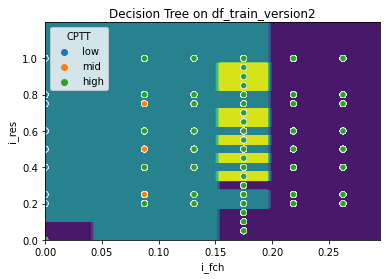

In [20]:
xx, yy = np.meshgrid(np.arange(0, 0.3, 0.005), np.arange(0, 1.2, 0.002))
Z_string = decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int)
sns.scatterplot(data = df_train, x = 'i_fch', y = 'i_res', hue = 'CPTT')
plt.title('Decision Tree on df_train_version2')

In [21]:
dt_training_accuracy = decision_tree_model.score(df_train[['i_ren', 'i_res']], df_train['CPTT'])
dt_test_accuracy = decision_tree_model.score(df_test[['i_ren', 'i_res']], df_test['CPTT'])
dt_training_accuracy, dt_test_accuracy

(0.24911675474897793, 0.24911675474897793)

In [22]:
random_forest_model = ensemble.RandomForestClassifier(n_estimators=20, random_state=42)
random_forest_model.fit(df_train[['i_ren', 'i_res']], df_train['CPTT'])

RandomForestClassifier(n_estimators=20, random_state=42)

C:\Users\xinyu\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


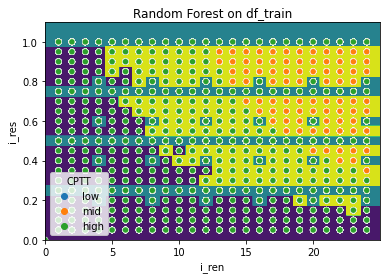

In [23]:
xx, yy = np.meshgrid(np.arange(0, 25, 0.02), np.arange(0, 1.1, 0.002))
Z_string = random_forest_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int)
sns.scatterplot(data = df_train, x = 'i_ren', y = 'i_res', hue = 'CPTT')
plt.title('Random Forest on df_train');

In [24]:
#### USE CPT for goal and split it w/ low mid high 
#### standard scaler mean max 
#   https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
##### max depth 20 
#

In [25]:
type(df['WOP'].max())

float

In [26]:
def basic_position(wop_value):
    if wop_value < (df['WOP'].max()/3):
        return 'low'
    elif wop_value < (df['WOP'].max() * 2/3) and wop_value >= (df['WOP'].max() * 1/3) :
        return 'med'
    return 'high'

df['WOPP'] = df['WOP'].apply(basic_position)
df['WOPP'].value_counts()

<ipython-input-26-aeedc7713f91>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['WOPP'] = df['WOP'].apply(basic_position)


med     305
high    175
Name: WOPP, dtype: int64

In [27]:
df_train, df_test= train_test_split(df, test_size=0.5, random_state=100)
df_train = df.sort_values(by='WOP')
df_test = df.sort_values(by='WOP')
df_test

,i_sex,i_ren,i_res,i_rsg,i_gsv,i_fch,i_fcb,i_fcr,i_hrm,i_hrf,i_grp,i_mig,TTI,TTO,WOP,POE,POF,CPT,MNF,WOPP
5,1,1,0.05,0.079,0.01,0.175,0.117,0.0,1.0,0.956,0,0.0,106.0,343.0,237.0,0.0,1.0,0.752805,0.015845,med
10,1,1,0.10,0.079,0.01,0.175,0.117,0.0,1.0,0.956,0,0.0,94.0,332.0,238.0,0.0,1.0,0.752316,0.015478,med
961,1,2,0.05,0.079,0.01,0.175,0.117,0.0,1.0,0.956,0,0.0,95.0,333.0,238.0,0.0,1.0,0.752289,0.015429,med
15,1,1,0.15,0.079,0.01,0.175,0.117,0.0,1.0,0.956,0,0.0,86.0,326.0,239.0,0.0,1.0,0.751914,0.015082,med
1917,1,3,0.05,0.079,0.01,0.175,0.117,0.0,1.0,0.956,0,0.0,89.0,328.5,239.5,0.0,1.0,0.751803,0.015166,med
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279799,1,23,0.95,0.079,0.01,0.175,0.117,0.0,1.0,0.956,0,0.0,32.0,584.5,552.5,0.0,1.0,0.594123,0.000006,high
322206,1,24,0.90,0.079,0.01,0.175,0.117,0.0,1.0,0.956,0,0.0,33.0,586.0,553.0,0.0,1.0,0.593228,0.000006,high
279974,1,23,1.00,0.079,0.01,0.175,0.117,0.0,1.0,0.956,0,0.0,32.0,590.0,558.0,0.0,1.0,0.590515,0.000006,high
322211,1,24,0.95,0.079,0.01,0.175,0.117,0.0,1.0,0.956,0,0.0,32.0,595.0,563.0,0.0,1.0,0.588371,0.000004,high


In [28]:
decision_tree_model.fit(df_train[['i_ren', 'i_res']], df_train['WOPP'])

DecisionTreeClassifier(random_state=42)

Text(0.5, 1.0, 'Decision Tree on df_train')

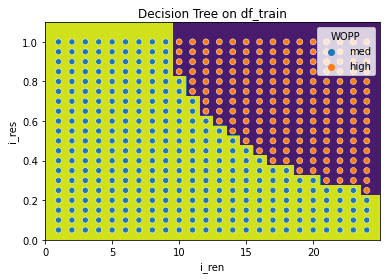

In [29]:
xx, yy = np.meshgrid(np.arange(0, 25, 0.02), np.arange(0, 1.1, 0.002))
Z_string = decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int)
sns.scatterplot(data = df_train, x = 'i_ren', y = 'i_res', hue = 'WOPP')
plt.title('Decision Tree on df_train')